In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions

path = '/media/robert/Data_Storage/Data/Tests/Electron_Beam2/'

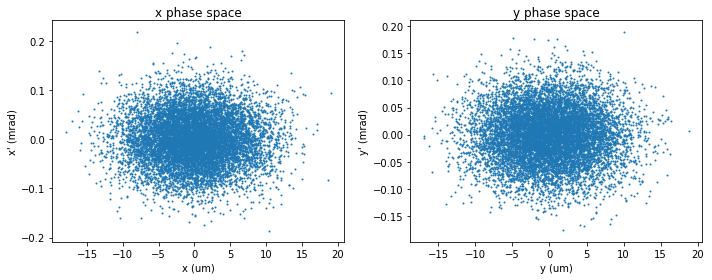

In [2]:
params = {
    'name' : 'TestBeam',
    'path' : path,
    'load' : False,
    'N' : 10000,
    'gamma' : 20000,
    'emittance' : 5e-6,
    'betax' : 0.10,
    'betay' : 0.10,
    'alphax' : 0.0,
    'alphay' : 0.0,
    'sigmaz' : 5e-6,
    'dE' : 0.01
}

beam = electronbeam.GaussianElectronBeam(params)
beam.plot_current_phase()

In [ ]:
# Now we can create a very simple plasma 